In [1]:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
from thejoker import JokerParams, TheJoker, RVData
from thejoker.sampler.io import save_prior_samples
from astropy.time import Time
import h5py

In [ ]:
JokerParams()

In [ ]:
TheJoker()

In [3]:
P_lim = [1e0, 1e5]
nsamples = 16384  # number of samples of the nonlinear parameter

Vdiag = np.array([1e3, 1e3]) ** 2
V = np.diag(Vdiag)

pars = JokerParams(P_min=P_lim[0]*u.day, P_max=P_lim[1]*u.day, 
                   linear_par_Vinv=np.diag(1/Vdiag))
joker = TheJoker(pars)

In [4]:
prior_samples = joker.sample_prior(size=nsamples)
prior_samples['e'] = np.zeros(len(prior_samples))
prior_samples['omega'] = np.zeros(len(prior_samples)) * u.radian
with h5py.File('/Users/apricewhelan/Downloads/test_joker.hdf5', 'w') as f:
    save_prior_samples(f, prior_samples, u.km/u.s, ln_prior_probs=np.zeros(nsamples))

Make fake data:

In [15]:
# np.random.seed(123)
np.random.seed(456)

N = 5  # number of data points
t = np.sort(np.random.uniform(0, 0.01, size=N))
sig_y = np.random.uniform(0.1, 0.5, size=N)  # noise! MAGIC NUMBER
C = np.diag(sig_y**2)
# y = 10 + np.random.normal(0., sig_y, size=N)
y = 0 + np.zeros(N)
data = RVData(t=t, rv=y*u.km/u.s, stddev=sig_y*u.km/u.s, t0=Time(0., format='mjd'))

# P_samples = np.exp(np.random.uniform(np.log(P_lim[0]), 
#                                      np.log(P_lim[1]),
#                                      size=nsamples))

# M0_samples = np.random.uniform(0, 2*np.pi, size=nsamples)

P_samples = prior_samples['P'].value #* 3.14
M0_samples = prior_samples['M0'].to_value(u.radian)

# hyperprior on linear parameters:
mu_th = np.array([0., 0])

In [16]:
M = np.stack((np.ones((N, nsamples)),
              np.cos(2*np.pi*t[:, None] / P_samples[None] - M0_samples[None]))).T

# M = np.stack((np.ones((N, nsamples)),
#               np.cos(2*np.pi*t[:, None] / P_samples[None]),
#               np.sin(2*np.pi*t[:, None] / P_samples[None]))).T

In [25]:
def get_aA_bB(M, y, C, mu, V):
    Cinv = np.linalg.inv(C)
    Vinv = np.linalg.inv(V)
    
    A = C + M.dot(V).dot(M.T)
    # Ainv = np.linalg.inv(A)
    Binv = Vinv + M.T.dot(Cinv).dot(M)
    B = np.linalg.inv(Binv)

    a = M.dot(mu)
    b = B.dot(M.T.dot(Cinv).dot(y) + Vinv.dot(mu))

    return a, A, b, B

In [34]:
lls = np.zeros(nsamples)
# lls_hogg = np.zeros(nsamples)
samples = np.zeros((nsamples, M.shape[-1]))
for i in range(nsamples):
    varK = (P_samples[i] / 1.)**(-2/3) * 45**2
#     V = np.diag([1e2**2, varK, varK])
    a, A, b, B = get_aA_bB(M[i], y, C, mu_th, V)
    lls[i] = multivariate_normal.logpdf(y, mean=a, cov=A)
    # s, logdetA = np.linalg.slogdet(2. * np.pi * A)
    # lls_hogg[i] = -0.5 * (y - a).dot(np.linalg.solve(A, (y - a))) - 0.5 * logdetA
    samples[i] = np.random.multivariate_normal(b, B)

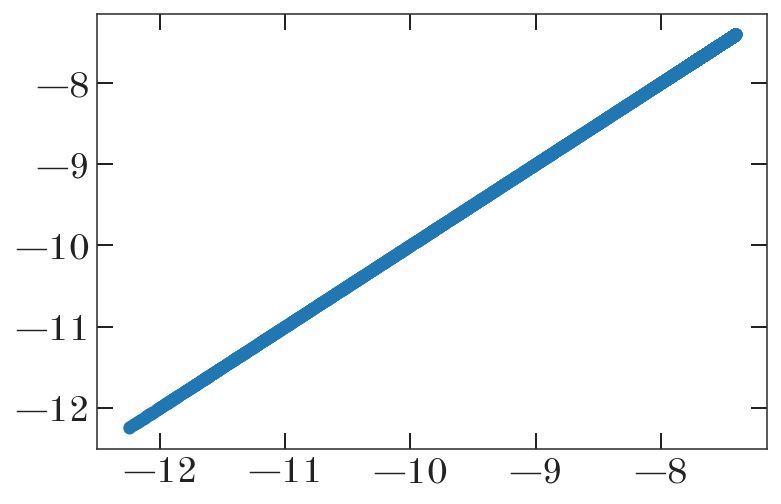

In [35]:
plt.scatter(lls, lls_hogg)

In [31]:
(N + len(mu_th)) * np.log(2*np.pi)

12.865139464865418

In [19]:
uu = np.random.uniform(size=nsamples)
good_samples_mask = uu < np.exp(lls - lls.max())

In [20]:
good_samples_mask.sum()

9643

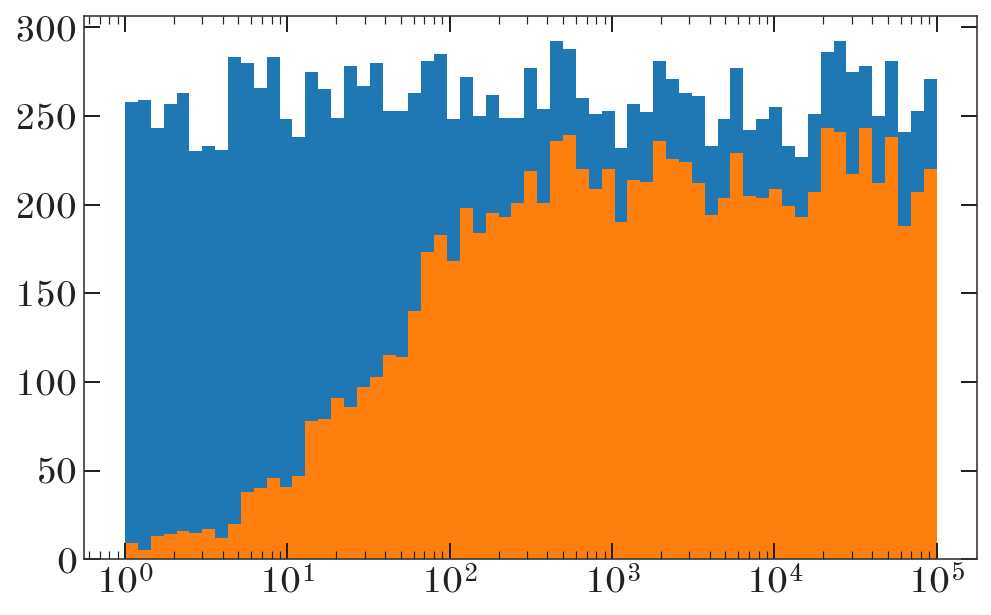

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(P_samples, bins=np.geomspace(P_lim[0], P_lim[1], 64))
ax.hist(P_samples[good_samples_mask], bins=bins)
ax.set_xscale('log')

---

In [22]:
from thejoker.sampler import compute_likelihoods
from schwimmbad import SerialPool

In [23]:
lnlike = compute_likelihoods(nsamples, '/Users/apricewhelan/Downloads/test_joker.hdf5', 0, data,
                             pars, SerialPool())

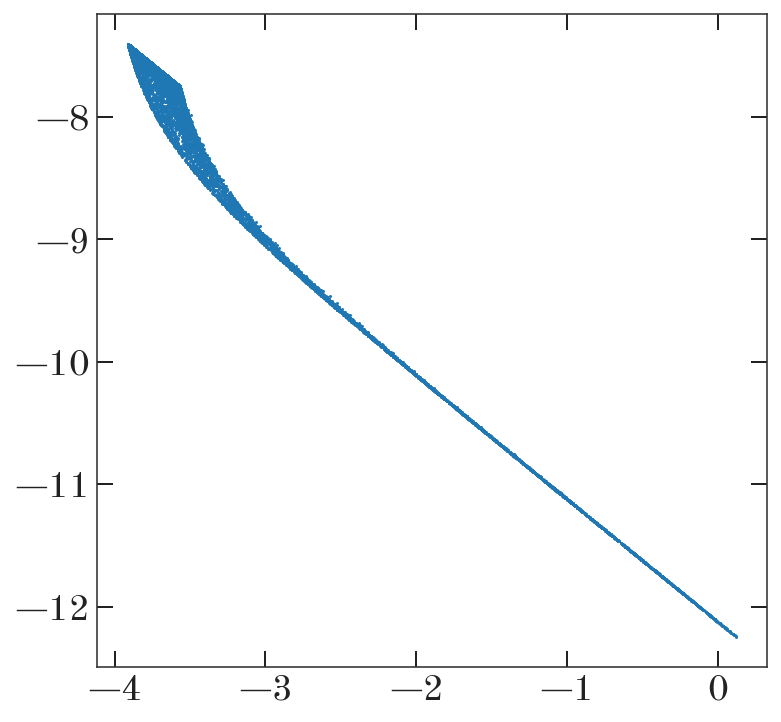

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(lnlike, lls, marker='o', ms=1.5, ls='none')

In [32]:
(lnlike - lls)[lls < -12]

array([12.04126185, 11.98536948, 12.1572256 , 12.08176927, 11.97290031,
       11.99451085, 12.21872917, 12.3431453 , 12.02139865, 12.14260872,
       12.09026361, 12.12527483, 12.30193288, 12.28429474, 12.14946766,
       11.92128703, 12.0167212 , 12.02309544, 11.93257493, 11.88483967,
       12.1024723 , 12.07741044, 12.10637775, 11.89658203, 12.22776179,
       12.28557164, 11.88107669, 12.2255943 , 12.14444173, 12.27739597,
       12.22038233, 12.23773182, 11.89846127, 12.0828604 , 11.91726603,
       12.24360124, 12.16470072, 12.14778458, 12.08839335, 12.03448783,
       11.93827126, 12.18620174, 12.21944496, 12.17241017, 12.2221489 ,
       12.11807506, 11.88543185, 12.33155043, 12.00873644, 12.04832028,
       12.03702329, 12.03010316, 12.25023467, 12.08746864, 12.36057808,
       12.14479812, 12.10520829, 12.23298526, 12.1933274 , 12.1870942 ,
       11.98500075, 12.19998562, 12.2503394 , 12.10302573, 12.06529529,
       12.21044921, 12.05947392, 12.02570456, 11.97285719, 12.08

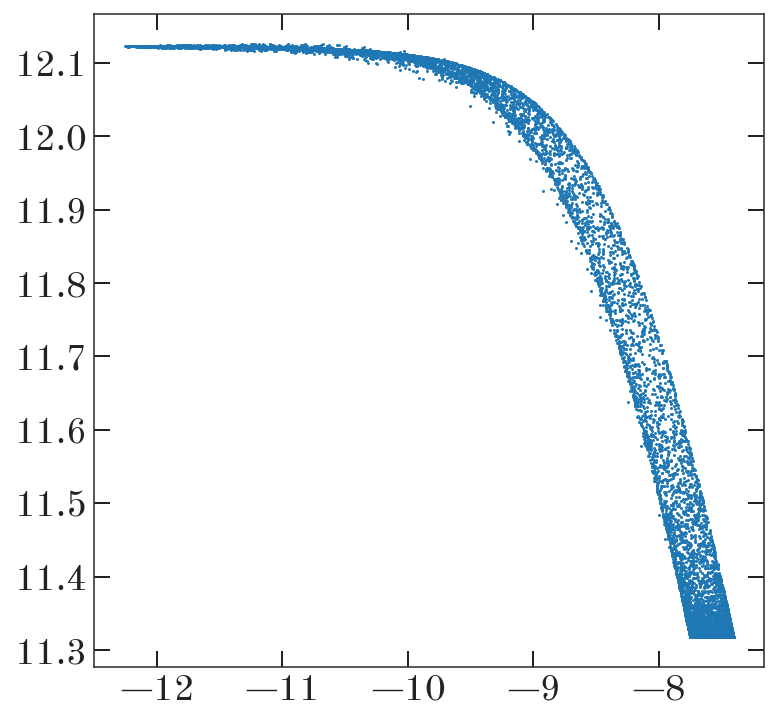

In [79]:
plt.figure(figsize=(6, 6))
plt.plot(lls, lnlike - lls, marker='o', ms=1.5, ls='none')

In [69]:
# joker_samples, lnprior, lnlike = joker.rejection_sample(
#     data, n_prior_samples=nsamples,
#     return_logprobs=True,
#     prior_cache_file='/Users/apricewhelan/Downloads/test_joker.hdf5')

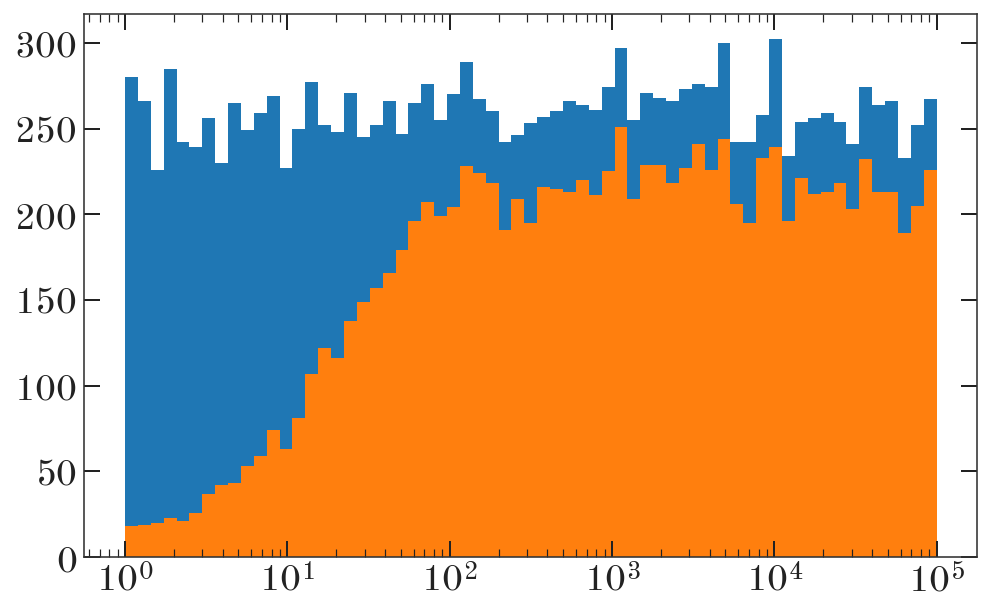

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(prior_samples['P'].value, bins=np.geomspace(P_lim[0], P_lim[1], 64))
ax.hist(joker_samples['P'].value, bins=bins)
ax.set_xscale('log')

---

In [64]:
phase_samples = np.arctan2(samples[:, 2], samples[:, 1])
amp_samples = np.sqrt(samples[:, 1]**2 + samples[:, 2]**2)

In [65]:
from corner import corner

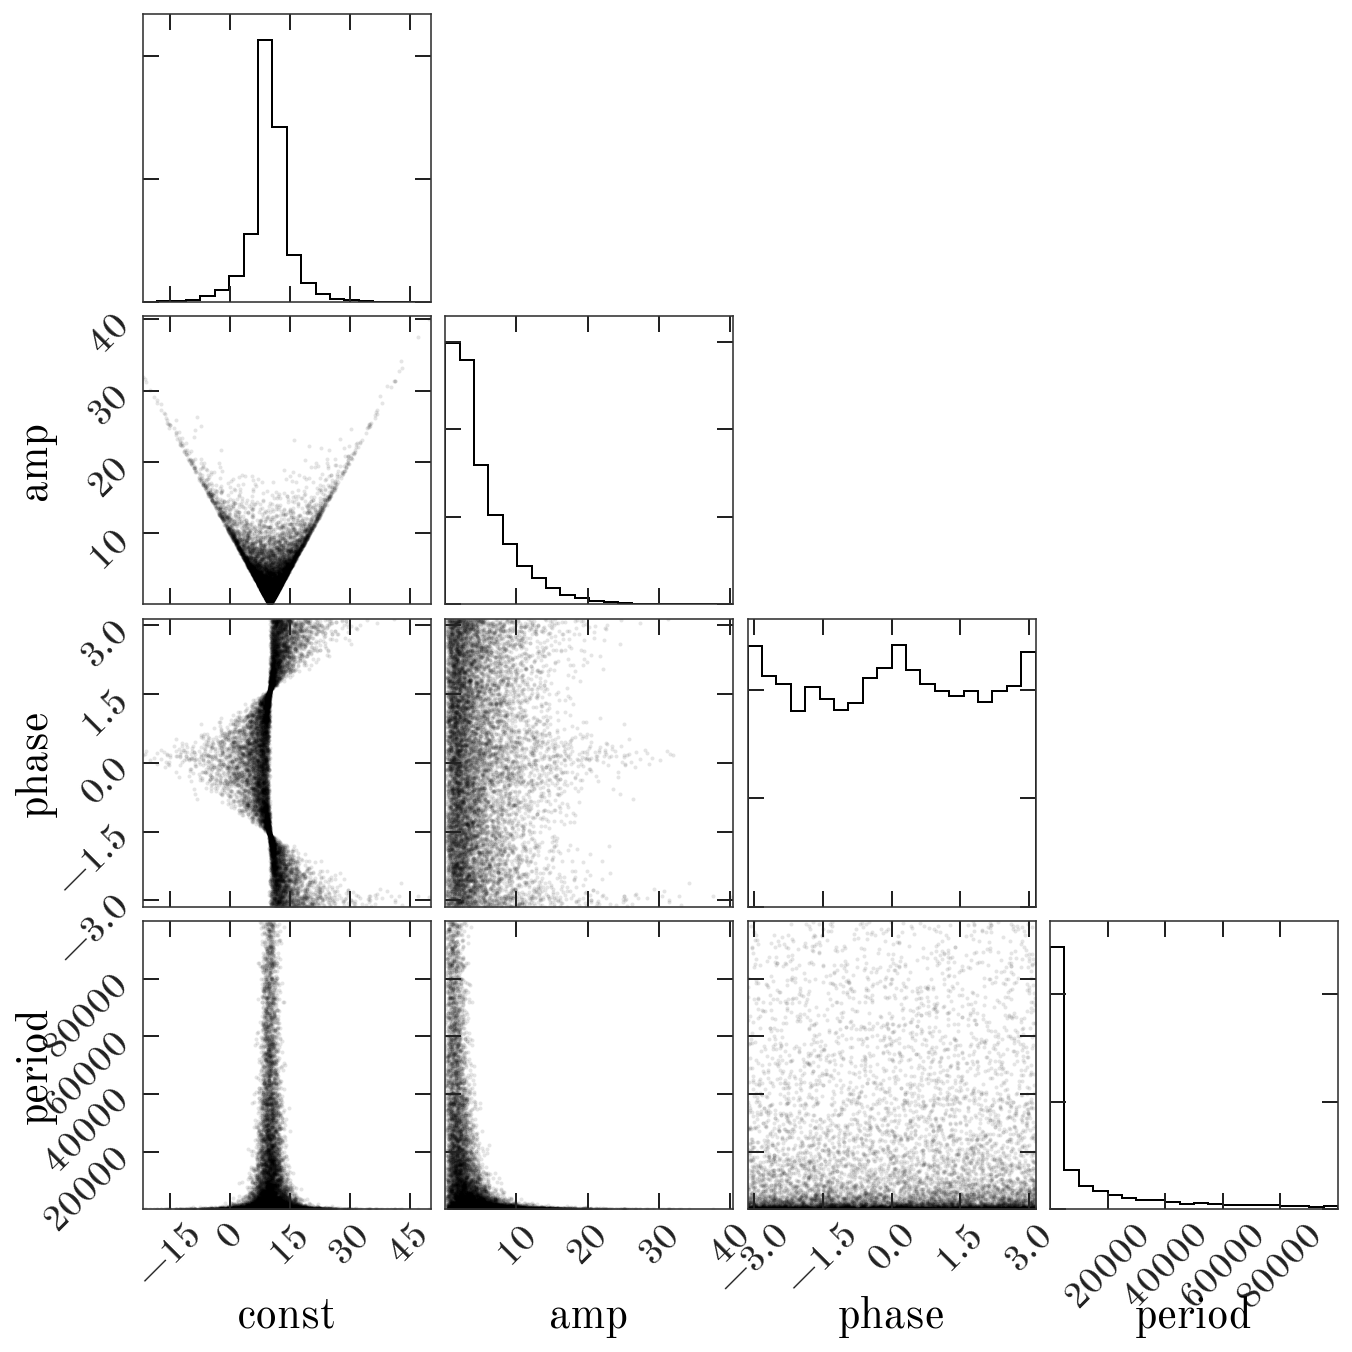

In [66]:
flat = np.stack((samples[:, 0], amp_samples, phase_samples, P_samples)).T[good_samples_mask]
_ = corner(flat, plot_contours=False, plot_density=False, labels=['const', 'amp', 'phase', 'period'])

(8.0, 12.0)

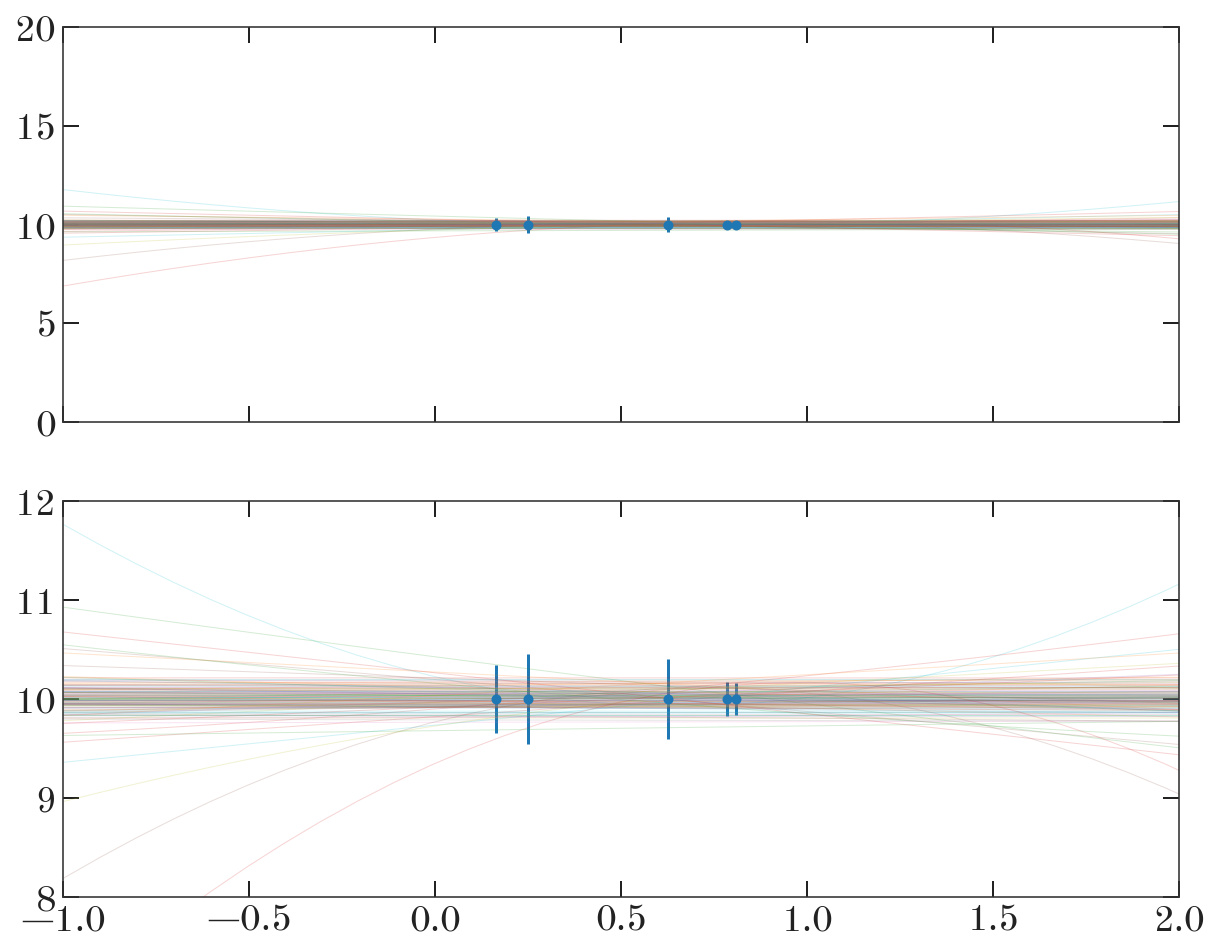

In [67]:
model_t = np.linspace(-1, 100., 1024)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for ax in axes:
    ax.errorbar(t, y, sig_y, marker='o', ls='none')

    for j in np.where(good_samples_mask)[0][:128]:
        ax.plot(model_t, 
                (samples[j][0] + samples[j][1] * np.cos(2*np.pi*model_t / P_samples[j]) + 
                 samples[j][2] * np.sin(2*np.pi*model_t / P_samples[j])),
                marker='', lw=0.5, alpha=0.2)

axes[0].set_ylim(0, 20)
axes[1].set_xlim(-1, 2)
axes[1].set_ylim(np.mean(y) - 2, np.mean(y) + 2)